# Hedging like a Quant

<b> YouTube Tutorial </b> (Published:
Aug 3, 2021): https://youtu.be/By3G_qs9ADU

Full worked example of the impact of delta hedging european options.


In [ ]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
!pip install --upgrade pandas_datareader

     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import datetime as dt
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

In [ ]:
end = dt.datetime.now()
start = dt.datetime(2020,1,1)

df = pdr.get_data_yahoo(['CBA.AX'], start, end)
Close = df.Close
Close.tail()

Symbols,CBA.AX
Date,
2022-02-08,99.559998
2022-02-09,100.779999
2022-02-10,98.550003
2022-02-13,100.040001
2022-02-14,99.250000


(Symbols
 CBA.AX    0.286422
 Name: 2022-02-14 00:00:00, dtype: float64, Symbols
 CBA.AX    99.25
 Name: 2022-02-14 00:00:00, dtype: float64)

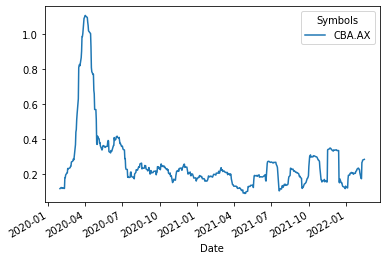

In [ ]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

# Implied Volatility

In [ ]:
## required for installing py_vollib
!pip install py_vollib

     |████████████████████████████████| 130 kB 7.3 MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=5a36ab554185f6d0b2e45f6af0a2a14892dc23d37e862d5ca03940749d284372
  Stored in directory: /root/.cache/pip/wheels/2d/25/50/bc80b93c9a827ed9bef9d86f85365e1934bcbc0666b9f00c11
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24468 sha256=2da649cabfbeabdb295f63418f26348137813e6be13c29c1d11ab0f04c598c33
  Stored in directory: /root/.cache/pip/wheels/1a/70/10/bf54a16badc528594c9510ef517badb765a29b651ea5652898
Successfully built py-vollib py-lets-be-rational


In [ ]:
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

In [ ]:
S0 = 102
atm_options = [
[dt.date(2021,10,18),102,[2.585,3.25],[4.600,5.300]],
]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3]

    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids,call_asks,put_bids,put_asks

([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

In [ ]:
K = 102
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

In [ ]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)

def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan

def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan

def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

In [ ]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'

call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300

# number of sims
M = 1000

# Realized Volatility
sigma = 0.12

# Position in Option contract
k = 102
position = 's'
flag = 'c'

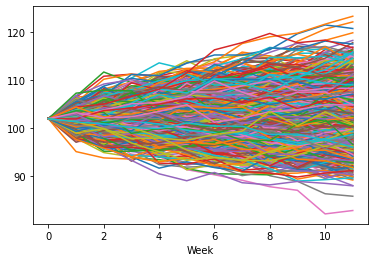

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,101.90,101.71,103.67,103.04,102.72,103.11,103.25,101.60,102.95,102.71,102.41,100.99,104.19,102.73,98.24,102.52,104.10,101.95,102.22,100.09,103.26,98.30,100.99,100.71,100.89,100.60,103.59,100.72,100.75,101.20,100.93,100.46,99.14,100.71,102.91,102.10,97.21,103.00,100.67,...,100.65,98.97,103.39,100.15,100.57,102.99,102.38,103.51,101.00,101.51,100.05,100.60,107.33,101.20,102.53,99.73,102.48,98.41,99.01,103.77,102.15,100.26,103.67,104.43,101.82,102.66,102.49,102.35,102.59,102.64,99.36,104.45,102.80,101.95,102.88,100.69,103.25,100.61,101.36,101.33
2,0.18,102.87,98.78,101.93,105.91,102.52,103.97,101.75,103.17,103.38,102.60,104.51,99.72,105.71,103.67,96.93,99.35,104.42,98.53,101.62,99.70,105.12,100.04,100.67,98.77,102.69,102.48,105.16,100.66,99.29,100.52,102.84,98.98,101.79,100.29,105.28,102.39,97.45,103.91,99.02,...,102.84,98.52,105.99,104.50,98.20,105.20,103.32,104.93,103.49,102.51,100.47,100.93,107.96,102.35,104.31,96.20,101.24,100.04,99.91,103.77,100.65,101.14,103.32,105.05,101.06,102.22,103.81,101.08,102.03,101.43,100.82,102.37,101.14,103.69,100.24,101.76,102.20,100.06,99.93,100.93
3,0.16,104.37,98.86,102.46,106.19,99.17,102.49,103.01,102.97,102.63,103.58,105.46,100.62,108.31,102.33,97.55,103.69,106.68,98.31,101.19,103.63,108.61,100.47,101.83,99.06,99.92,101.47,105.87,101.74,97.07,100.55,103.41,100.19,99.43,99.90,104.98,103.39,96.80,105.08,101.57,...,102.78,98.83,105.48,104.18,98.95,101.37,100.18,103.57,102.92,105.23,103.09,101.62,107.80,101.57,103.63,96.48,100.70,100.25,96.94,104.60,99.45,102.52,98.93,106.66,102.06,101.73,105.12,102.85,100.22,101.49,102.31,102.99,101.86,104.23,100.52,104.03,102.38,102.15,97.84,100.14
4,0.14,105.96,98.93,104.58,108.54,98.62,102.16,104.90,103.41,102.94,102.70,107.18,100.69,105.90,100.91,98.32,102.22,105.18,95.75,97.58,104.28,110.57,100.50,101.83,100.85,101.77,102.94,106.54,101.78,97.30,100.56,103.59,101.64,100.31,98.73,104.27,103.73,96.82,103.69,100.05,...,104.08,96.08,104.74,104.42,96.87,101.61,99.43,103.11,103.23,108.19,102.14,103.82,103.22,101.65,105.25,96.99,100.09,100.65,95.09,106.99,103.14,101.62,99.94,108.15,103.11,102.73,105.38,102.59,98.22,100.90,104.51,104.04,101.85,105.03,103.17,102.82,103.53,101.99,97.95,99.95
5,0.12,105.67,101.85,109.55,108.41,98.80,102.58,102.66,106.20,100.74,103.34,108.84,99.30,105.18,101.10,100.30,104.08,105.93,96.67,94.86,101.57,110.94,102.54,104.43,101.21,103.11,102.61,107.78,99.45,96.80,97.32,104.15,99.99,100.80,100.05,105.90,106.53,96.60,102.83,101.89,...,101.85,97.12,104.80,104.92,97.65,102.06,100.60,104.05,100.55,107.37,101.40,103.58,102.97,100.58,104.71,98.31,100.26,103.08,93.32,105.89,104.34,104.86,99.90,111.55,101.91,100.76,106.57,104.70,95.47,99.58,104.03,104.74,101.19,106.15,100.84,100.68,104.92,98.81,97.50,101.10
6,0.10,105.88,100.29,109.72,108.92,98.11,103.14,105.79,105.84,97.06,102.70,108.57,101.16,104.39,101.08,103.62,104.19,107.30,97.41,92.51,103.60,109.71,101.76,103.64,102.93,102.23,101.99,105.10,103.08,95.43,99.32,103.64,101.51,103.34,97.77,107.08,104.56,98.36,102.45,104.73,...,103.89,96.67,104.15,103.64,98.48,102.52,101.08,104.11,

In [ ]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)

no_hedge = []
static_hedge = []

# number of sims

St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)

St_series = np.array(St_series)

df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df

## Build up delta hedging dataframe with specific factors:
 - delta
 - total delta positions
 - number of adjustments
 - adjustment cashflow
 - interest on adjustments

 We can then sum the columns over the 11 weeks of delta heding and calculate the carry on options, carry on stock, option p&l, stock p&l and adjustment p&l and interest earned on adjustments.

In [ ]:
for sim in range(M):
    hedgeSim = df.loc[:,['Time',sim]]
    hedgeSim.columns = ['Time', 'Price']

    # hedge calcs
    hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'], K, x['Time'], r, sigma, position), axis=1)
    hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
    totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Contracts'] = hedgeSim.apply(lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
    hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],x['Time']), axis=1)
    hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+2)]
    hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(lambda x: cashAdj(x['Total Delta Position'],x['Price'],x['Time'], x['totaladjust_c']), axis=1)
    hedgeSim['Interest on Adjustments'] = hedgeSim.apply(lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2), axis=1)
    hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])

    # calculate payoffs
    if flag == 'c':
        if position == 's':
            optprice = call_bid
            option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
            # delta will be negative if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be negative if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = call_ask
            option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
            # delta will be positive if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be positive if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

    elif flag == 'p':
        if position == 's':
            optprice = put_bid
            option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
            # delta will be positive if short
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = 100*optprice*r*T
            # delta will be positive if short
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
        else:
            optprice = put_ask
            option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
            # delta will be negative if long
            stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
            adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
            option_carry = -100*optprice*r*T
            # delta will be negative if long
            stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
            int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

    data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]

    #add to dataframe
    Dynamic_sim = pd.DataFrame(data=data, columns=[sim], index=['Original Option P&L','Original Stock P&L','Adjustment P&L', \
                                                                             'Carry (interest) on options', 'Carry (interest) on stock', \
                                                                             'Interest on Adjustments'])
    Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
    no_hedge.append(option_pnl+option_carry)
    static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)


## Delta Hedging P&L
- sum all contributions for Total Cashflow for each simulation

In [ ]:
Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',] = Dynamic_Hedging_Results.sum(axis=0)
Dynamic_Hedging_Results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
Dynamic hedging results,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Original Option P&L,-525.500000,82.500000,-612.500000,-1194.500000,258.500000,-584.500000,202.500000,-339.500000,258.500000,142.500000,-991.500000,258.500000,258.500000,258.500000,-346.500000,-49.500000,-60.500000,258.500000,258.500000,258.500000,-449.500000,-157.500000,-250.500000,-235.500000,181.500000,258.500000,258.500000,-261.500000,258.500000,258.500000,258.500000,258.500000,174.500000,258.500000,258.500000,-486.500000,258.500000,258.500000,187.500000,168.500000,...,-132.500000,24.500000,-129.500000,258.500000,258.500000,258.500000,258.500000,104.500000,258.500000,-444.500000,164.500000,258.500000,216.500000,258.500000,258.500000,252.500000,258.500000,258.500000,258.500000,-68.500000,-10.500000,104.500000,258.500000,-1221.500000,258.500000,142.500000,-34.500000,-302.500000,258.500000,258.500000,-251.500000,241.500000,258.500000,6.500000,174.500000,258.500000,-28.500000,258.500000,258.500000,258.500000
Original Stock P&L,423.360000,95.040000,470.340000,784.620000,-211.680000,455.220000,30.240000,322.920000,-257.040000,62.640000,675.000000,-383.400000,-38.340000,-225.720000,326.700000,166.320000,172.260000,-286.740000,-515.700000,-42.120000,382.320000,224.640000,274.860000,266.760000,41.580000,-199.800000,-66.420000,280.800000,-334.800000,-91.800000,-66.960000,-67.500000,45.360000,-83.700000,-32.400000,402.300000,-86.940000,-30.240000,38.340000,48.600000,...,211.140000,126.360000,209.520000,-69.120000,-72.900000,-219.240000,-403.920000,83.160000,-71.820000,379.620000,50.760000,-448.740000,22.680000,-80.460000,-8.640000,3.240000,-120.420000,-204.660000,-306.180000,176.580000,145.260000,83.160000,-90.720000,799.200000,-282.960000,62.640000,158.220000,302.940000,-119.880000,-319.140000,275.400000,9.180000,-290.520000,136.080000,45.360000,-92.340000,154.980000,-209.520000,-59.940000,-178.740000
Adjustment P&L,179.620000,-88.250000,127.850000,442.410000,-13.410000,189.400000,-166.560000,80.720000,1.770000,-101.960000,372.310000,185.040000,-165.330000,64.710000,-11.820000,-113.260000,-27.580000,-57.050000,244.180000,-269.420000,92.940000,-49.880000,-110.700000,-47.120000,-166.530000,36.360000,-133.760000,-7.140000,104.340000,-85.930000,-194.720000,-84.020000,-193.750000,-64.720000,-158.800000,142.450000,-166.830000,-130.710000,-149.390000,-230.960000,...,-7.690000,-178.280000,-69.570000,-157.490000,-123.490000,-83.960000,169.180000,-58.440000,-139.680000,84.020000,-154.920000,204.820000,-345.280000,-84.690000,-77.760000,-275.080000,-86.810000,-132.960000,23.400000,-13.770000,-74.990000,-199.880000,-183.710000,444.060000,50.390000,-71.410000,-59.270000,70.360000,-124.430000,150.310000,22.770000,-115.070000,-78.610000,-53.500000,-155.850000,-64.940000,-52.000000,-21.980000,-327.450000,22.540000
Carry (interest) on options,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,...,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151
Carry (interest) on stock,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24.144658,-24

## Visualise distributions
 - hedging
 - static hedge (at entry only)
 - no delta heding

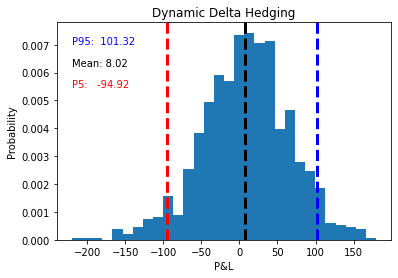

In [ ]:
x = Dynamic_Hedging_Results.loc['TOTAL CASHFLOW',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()

if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

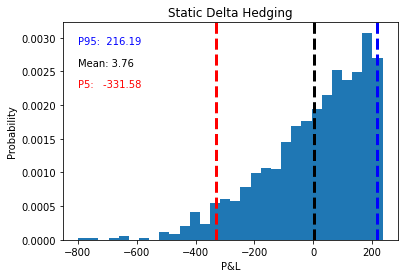

In [ ]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')

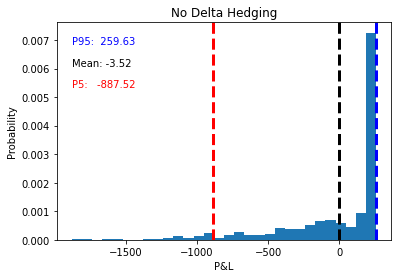

In [ ]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(np.percentile(x,5))).set_color('red')